In [1]:
import numpy as np
import torch
import torch.nn.functional as F
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

### Load Q, K, V

Load q, k, v from GPT-2 run on WMT (see end of notebook for data collection)

In [58]:
e = 400

qkv = np.load('qkv.npz')
n_layer, n_sample, n_attn_heads, l, d = qkv['q'].shape  # [ layers X samples X attention heads X tokens X q dimension ]

sample_dims = np.random.randint(0, n_sample * n_attn_heads, (n_layer,))
sample_mask = torch.zeros(n_layer, n_sample * n_attn_heads).type(torch.bool)
sample_mask[np.arange(n_layer), sample_dims] = True

# sample along sample and attention head dimensions
q, k, v = (
    torch.Tensor(qkv[n]).reshape(n_layer, n_sample * n_attn_heads, l, d)[sample_mask]
    for n in ('q', 'k', 'v')
)

# # without sampling
# qkv = np.load('qkv.npz')
# n_layer, n_sample, n_attn_heads, l, d = qkv['q'].shape  # [ layers X samples X attention heads X tokens X q dimension ]
# q, k, v = (
#     torch.Tensor(qkv[n]).reshape(n_layer, n_sample * n_attn_heads, l, d)
#     for n in ('q', 'k', 'v')
# )

### Run decomposition
Approximate within-softmax QK decomposition to bring dimensionality reduction outside softmax

In [59]:
A_ = q @ k.transpose(-1, -2)
causal_mask = torch.tril(torch.ones_like(A_, dtype=torch.bool))
A_[~causal_mask] = -float("inf")
A = torch.softmax(A_, dim=-1)
out = A @ v

In [60]:
# per attention-sinks paper, remove first 4 positions from attention matrix
n_sinks = 4
A = A[...,n_sinks:,n_sinks:]
k = k[...,n_sinks:,:]
v = v[...,n_sinks:,:]

### Attention analysis

In [136]:
# Get average softmax attention matrices with/without attention sinks
n_samples = 50
n_sinks = 4
L = 400
n_layer = 12
A_max_nosink = torch.zeros(n_layer, L - n_sinks, L - n_sinks)
As_nosink = torch.zeros(n_layer, L - n_sinks, L - n_sinks)
As_sink = torch.zeros(n_layer, L, L)
for i in tqdm(range(n_samples)):
    sample_dims = np.random.randint(0, n_sample * n_attn_heads, (n_layer,))
    sample_mask = torch.zeros(n_layer, n_sample * n_attn_heads).type(torch.bool)
    sample_mask[np.arange(n_layer), sample_dims] = True
    
    # sample along sample and attention head dimensions
    q, k, v = (
        torch.Tensor(qkv[n]).reshape(n_layer, n_sample * n_attn_heads, l, d)[sample_mask]
        for n in ('q', 'k', 'v')
    )

    A_ = q @ k.transpose(-1, -2)
    causal_mask = torch.tril(torch.ones_like(A_, dtype=torch.bool))
    A_[~causal_mask] = -float("inf")
    A = torch.softmax(A_, dim=-1)
    out = A @ v

    As_sink += A
    As_nosink += A[...,n_sinks:,n_sinks:]
    A_max_nosink += A[...,n_sinks:,n_sinks:].cummax(dim=-1).values  # average cumulative max attention weight over all prior keys
    A_max_nosink[~causal_mask[...,n_sinks:,n_sinks:]] = 0

As_sink /= n_samples
As_nosink /= n_samples
A_max_nosink /= n_samples

  0%|          | 0/50 [00:00<?, ?it/s]

Visualize attention weight distribution

Text(0.5, 0.98, 'Distribution of attention weights per layer (w/o attention sinks)')

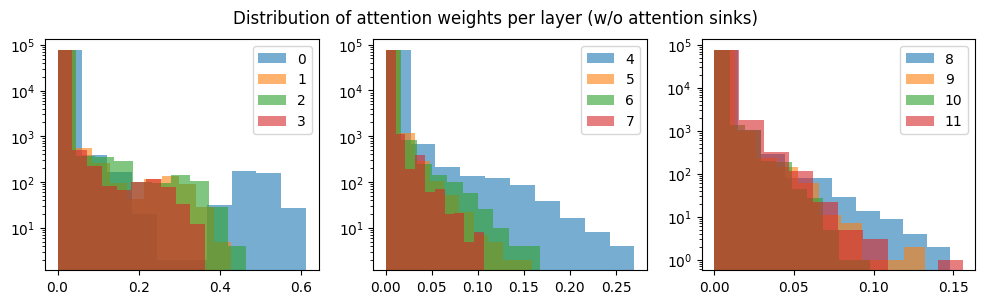

In [94]:
# excluding attention sinks
n_plot = 3
per_plot = n_layer // n_plot
f, ax = plt.subplots(1, n_plot, figsize=(12, 3))
for i in range(n_layer):
    A__ = As_nosink[i]
    ax_idx = i // per_plot
    ax[ax_idx].hist(A__[A__ != 0], label=i, alpha=0.6)
    ax[ax_idx].legend()
    ax[ax_idx].set_yscale('log')
f.suptitle('Distribution of attention weights per layer (w/o attention sinks)')

Observations:
- Clear bimodal distribution for first 4 layers
- Decrease in expected attention weight as depth increases

Create shifted view of attetnion matrix for q-k distance analyses

In [137]:
As = [As_sink, As_nosink, A_max_nosink]
As_shifted = []
total_masked = []
for A in [As_sink, As_nosink, A_max_nosink]:
    b = torch.arange(A.shape[-1])[None].repeat(A.shape[-1], 1)
    shifts = torch.arange(A.shape[-1])
    b = (b + 1 + shifts[:,None]) % A.shape[-1]
    
    # attention matrix with rows shifted by query position
    # column i contains attention weights assigned by queries to the key L - i - 1 positions before them
    A_shifted = torch.gather(A, -1, b[None].repeat(A.shape[0], 1, 1))
    total_masked += [torch.arange(A.shape[1]) + 1]

    As_shifted += [A_shifted]

Visualize max attention by q-k distance at different layers

Text(0.5, 0.98, 'Avg max past attention weight by q-k distance per layer (w/o attention sinks)')

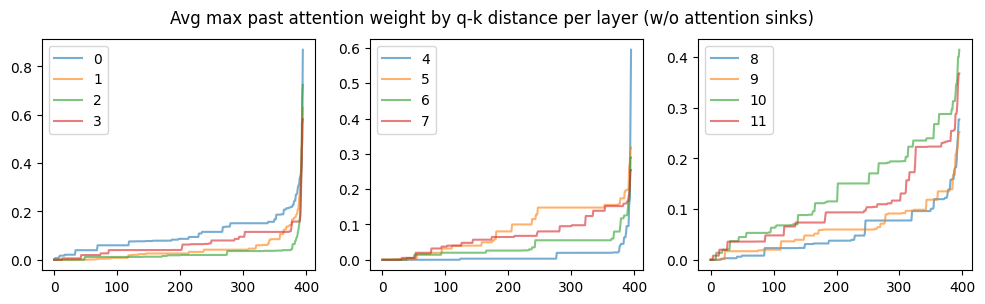

In [139]:
cummax = As_shifted[2]  # avg max attention weight for q-k distance >= x

n_plot = 3
per_plot = n_layer // n_plot
f, ax = plt.subplots(1, n_plot, figsize=(12, 3))
for i in range(n_layer):
    A__ = As_shifted[2][i]
    ax_idx = i // per_plot
    ax[ax_idx].plot(A__.max(dim=-2).values, label=i, alpha=0.6)
    ax[ax_idx].legend()
f.suptitle('Avg max past attention weight by q-k distance per layer (w/o attention sinks)')

Observations:
- on average, later layers attend more to earlier keys
- all layers can attend highly to early keys

Visualize average attention by q-k distance

Text(0.5, 1.0, 'Average attention sink attention allocation by layer')

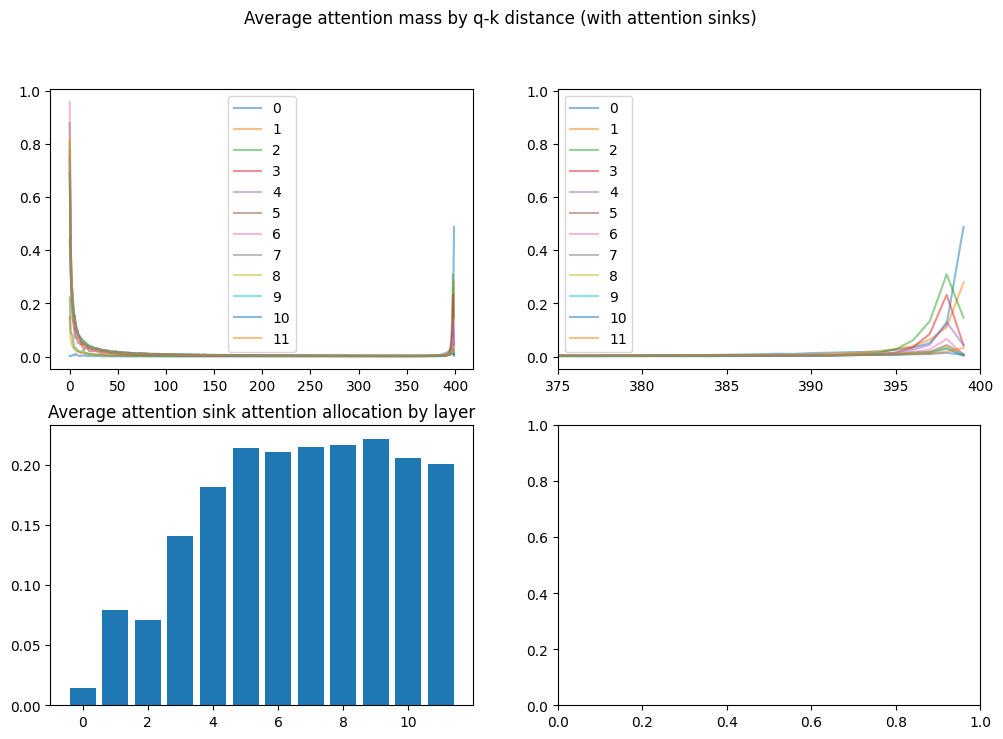

In [77]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

for i in range(12):
    ax[0, 0].plot(As_shifted[0][i].sum(dim=-2) / total_masked[0], label=i, alpha=0.5)
    ax[0, 1].plot(As_shifted[0][i].sum(dim=-2) / total_masked[0], label=i, alpha=0.5)
ax[0, 0].legend()
ax[0, 1].legend()
fig.suptitle("Average attention mass by q-k distance (with attention sinks)")
ax[0, 1].set_xlim(375, 400)
ax[1, 0].bar(np.arange(n_layer), As_sink[:,:,:n_sinks].mean(dim=-1).mean(dim=-1))
ax[1, 0].set_title("Average attention sink attention allocation by layer")

(375.0, 400.0)

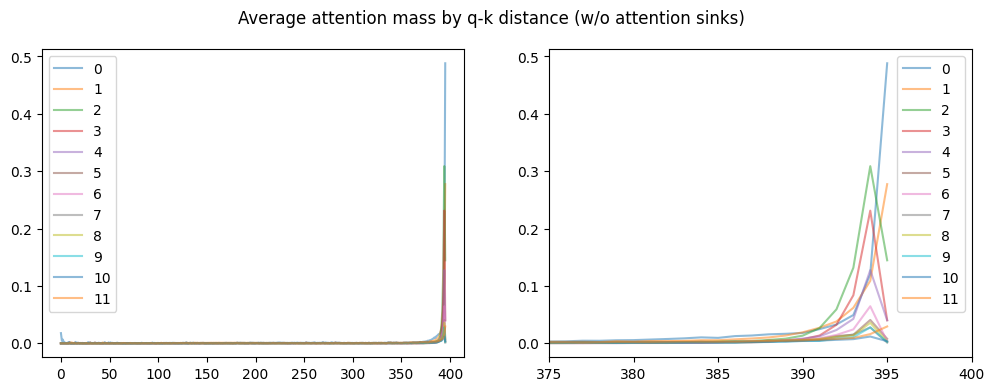

In [72]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
for i in range(12):
    ax[0].plot(As_shifted[1][i].sum(dim=-2) / total_masked[1], label=i, alpha=0.5)
    ax[1].plot(As_shifted[1][i].sum(dim=-2) / total_masked[1], label=i, alpha=0.5)
ax[0].legend()
ax[1].legend()
fig.suptitle("Average attention mass by q-k distance (w/o attention sinks)")
ax[1].set_xlim(375, 400)

Observations:
- first attention layer places most attention on current token
- even the 5th key shows evidence of attention-sink behavior in rare cases
- 1st, 2nd and last layers seem to attribute most attention to current token
- all other layers attribute most attention, on average, to previous tokens
- attention allocation to sink-keys increases steadily by depth until half-way through the network, then stabilizes

### Test forward-generalization of compression



Using eviction only approach (no value aggregation)

In [215]:
# plot number of evicted tokens based on fit token set with number of tokens that remain evicted on full set given varying threshold
# Get average softmax attention matrices with/without attention sinks
n_samples = 50
n_sinks = 4
L = 400
n_layer = 12
n_evicted_fit = torch.zeros(n_layer, L - n_sinks)
n_evicted_precision = torch.zeros(n_layer, L - n_sinks)
n_k = torch.arange(1, L - n_sinks + 1)
evicted_t = 1 / n_k
for i in tqdm(range(n_samples)):
    sample_dims = np.random.randint(0, n_sample * n_attn_heads, (n_layer,))
    sample_mask = torch.zeros(n_layer, n_sample * n_attn_heads).type(torch.bool)
    sample_mask[np.arange(n_layer), sample_dims] = True
    
    # sample along sample and attention head dimensions
    q, k, v = (
        torch.Tensor(qkv[n]).reshape(n_layer, n_sample * n_attn_heads, l, d)[sample_mask]
        for n in ('q', 'k', 'v')
    )

    A_ = q @ k.transpose(-1, -2)
    causal_mask = torch.tril(torch.ones_like(A_, dtype=torch.bool))
    A_[~causal_mask] = -float("inf")
    A = torch.softmax(A_, dim=-1)
    #out = A @ v

    # compute number of evicted keys given a fit token set up to each query position
    not_evicted = ((A[...,n_sinks:,n_sinks:] >= evicted_t[None,:,None]).cumsum(dim=-2) > 0)
    evicted = (~not_evicted) & causal_mask[...,n_sinks:,n_sinks:]
    evicted_gt = ~not_evicted[:,-1:]

    evicted_sum = evicted.sum(dim=-1)
    remain_evicted = evicted & evicted_gt
    n_evicted_fit += evicted_sum / n_k[None]
    n_evicted_precision += remain_evicted.sum(dim=-1) / torch.maximum(evicted_sum, torch.tensor(1))

n_evicted_precision /= n_samples
n_evicted_fit /= n_samples

  0%|          | 0/50 [00:00<?, ?it/s]

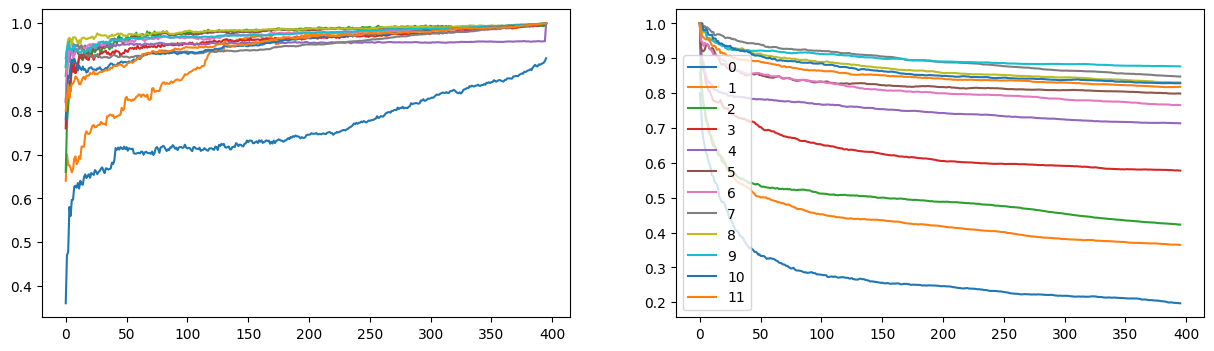

In [216]:
_, ax = plt.subplots(1, 2, figsize=(15, 4))
for i in range(n_layer):
    ax[0].plot(n_evicted_precision[i], label=i)
    ax[1].plot(n_evicted_fit[i], label=i)
#ax[0].legend()
ax[1].legend()

Observations:
- surprisingly stable over short contexts of wikitext
- early layers show low amount of eviction (inline with findings of Liu et al (scissorhands)), maybe bc likelihood of attention to local tokens is higher

Using rank-1 aprroximation for evicted keys (A-sim)

In [140]:
# plot number of thresholded A-sim key pairs over fit token set with number of these pairs that remain thresholded over the full token set (fit + eval)

Test generalization of compressed representation (k selection and v aggregation)

- for each size of compression (number of saved keys):
    - for each fit size (number of queries used to determine which keys are saved)
        - compute L2 error of attention over next n queries


In [360]:
# exclude overlap of q and k tokens
n_tok = A.shape[-1] // 2
A = A[...,n_tok:,:n_tok]
k = k[...,:n_tok,:]
v = k[...,:n_tok,:]

In [338]:
class SameBasisLowRankAttn:
    pass

In [363]:
# put K dimension first
A_t = A.transpose(-2, -1)

# try normalizing
A_t_mean = A_t.mean(dim=-2)[...,None,:]
A_t_centered = A_t - A_t_mean
A_t_sd = ((A_t_centered - A_t_mean) ** 2).mean(dim=-2) ** 0.5
A_t_norm = A_t_centered / A_t_sd[...,None,:]

A_t = A_t_norm

# track how much of each key's information remains as we go
accounted_A = torch.zeros(A_t.shape[:-1], dtype=A_t.dtype, device=A_t.device)

saved_ks = []
saved_vs = []

sums = []
lsq = []

for i in tqdm(range(e)):
    L2s = (A_t ** 2).sum(dim=-1)
    max_L2s = torch.max(L2s, dim=-1)
    dims = get_tensor_elem_idx(*max_L2s.indices.shape)
    ks = torch.zeros_like(L2s)
    ks[...] = A_t[(*dims, max_L2s.indices.flatten())]

    # compute value aggregation for selected keys based on their contributions to the attention patterns of other keys
    least_squares_w = (ks[...,None,:] * A_t).sum(dim=-1) / max_L2s.values[...,None]
    least_squares_w[max_L2s.values == 0] = 0
    # least_squares_w[max_idxs] == 1
    vs = torch.zeros_like(v[...,0,:])
    vs[...] = (least_squares_w[...,None] * v).sum(dim=-2)

    # compute attention matrix remainder
    A_t = A_t - ks[...,None,:] * least_squares_w[...,None]    

    sums += [((A_t - A_t_norm)**2).sum(dim=-2).max(dim=-1).values]
    lsq += [least_squares_w]
    
    saved_ks += [ks]
    saved_vs += [vs]

  0%|          | 0/400 [00:00<?, ?it/s]

In [ ]:
class SVDLowRankAttn:

    def compress(A, compress_offset, compress_range, n_compress, fit_offset, n_fit):
        """
        Generate a low-rank approximation of the passed attention matrix for evaluation purposes
        A: normalized attention matrix
        compress_range: number of tokens in range of keys being compressed
        n_compress: number of tokens to compress to (<= compress_range)
        fit_offset: number of tokens between the keys being compressed and queries used to fit the compression
        n_fit: number of tokens spanned by the queries used to fit the compression
        """
        assert compress_range >= n_compress
        compress_end = compress_offset + compress_range
        fit_start = compress_end + fit_offset
        fit_end = fit_start + n_fit
        A_compress = A[...,fit_start:fit_end,compress_offset:compress_end]

        U, s, D = torch.linalg.svd(A_compress)
        S = torch.diag_embed(s, dim1=-2, dim2=-1)

        # take highest singular value vectors
        U = U[...,:,:n_compress]
        S = S[...,:n_compress,:n_compress]
        D = D[...,:n_compress,:]

        A[...,fit_start:fit_end,:compress_range] = U @ S @ D

### SVD approximation

In [59]:
U, s, D = torch.linalg.svd(A)
S = torch.diag_embed(s, dim1=1, dim2=2)

# take highest singular value vectors
U = U[...,:,:e]
S = S[...,:e,:e]
D = D[...,:e,:]

A_p = U @ S @ D

In [60]:
(A_p - A).abs().mean()

tensor(3.7001e-05)

### Same-basis approximation

First try naive approach, select largest contributing key greedily

In [307]:
# put K dimension first
A_t = A.transpose(-2, -1)

# track how much of each key's information remains as we go
accounted_A = torch.zeros(A_t.shape[:-1], dtype=A_t.dtype, device=A_t.device)

saved_ks = []
saved_vs = []

sums = []
lsq = []

for i in tqdm(range(e)):
    L2s = (A_t ** 2).sum(dim=-1)
    max_L2s = torch.max(L2s, dim=-1)
    dims = get_tensor_elem_idx(*max_L2s.indices.shape)
    ks = torch.zeros_like(L2s)
    ks[...] = A_t[(*dims, max_L2s.indices.flatten())]

    # compute value aggregation for selected keys based on their contributions to the attention patterns of other keys
    least_squares_w = (ks[...,None,:] * A_t).sum(dim=-1) / max_L2s.values[...,None]
    least_squares_w[max_L2s.values == 0] = 0
    # least_squares_w[max_idxs] == 1
    vs = torch.zeros_like(v[...,0,:])
    vs[...] = (least_squares_w[...,None] * v).sum(dim=-2)

    # compute attention matrix remainder
    A_t = A_t - ks[...,None,:] * least_squares_w[...,None]    

    sums += [A_t.sum(dim=-2).max(dim=-1).values]
    lsq += [least_squares_w]
    
    saved_ks += [ks]
    saved_vs += [vs]

  0%|          | 0/400 [00:00<?, ?it/s]

(0.0, 0.2)

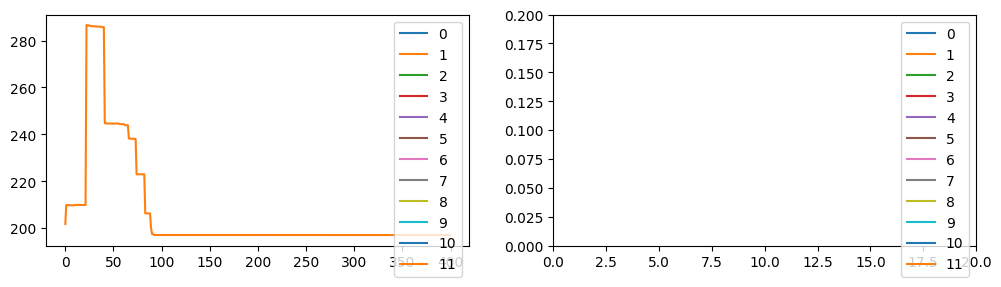

In [364]:
_, ax = plt.subplots(1, 2, figsize=(12, 3))
for l in range(12):
    ax[0].plot([s[l] for s in sums], label=l)
    ax[1].plot([s[l] for s in sums], label=l)

ax[0].legend()
ax[1].legend()
ax[1].set_xlim(0,  20)
ax[1].set_ylim(0, 0.2)


#### Evaluate forward generalization

In [278]:
A_t.sum(dim=-2).max(dim=-1)

torch.return_types.max(
values=tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 6.0592e-26, 0.0000e+00, 2.3453e-23,
        1.0232e-23, 2.4967e-23, 4.6096e-24, 3.6085e-23, 2.6668e-24, 2.4862e-23]),
indices=tensor([  0,   0,   0, 119,   0, 228,  46,  74, 382, 383, 168, 246]))

In [277]:
[v_.abs().sum() for v_ in lsq]

[tensor(12.8341),
 tensor(13.1459),
 tensor(12.6071),
 tensor(12.8484),
 tensor(13.3568),
 tensor(13.1297),
 tensor(13.0638),
 tensor(13.4788),
 tensor(13.3054),
 tensor(13.3091),
 tensor(12.9544),
 tensor(12.7360),
 tensor(13.3922),
 tensor(12.9341),
 tensor(13.1211),
 tensor(13.1491),
 tensor(13.7497),
 tensor(13.2308),
 tensor(12.9965),
 tensor(12.9622),
 tensor(13.4190),
 tensor(12.8736),
 tensor(13.1177),
 tensor(13.0632),
 tensor(13.0077),
 tensor(12.8666),
 tensor(12.6950),
 tensor(13.2073),
 tensor(13.9375),
 tensor(13.5100),
 tensor(13.1752),
 tensor(13.2578),
 tensor(12.8959),
 tensor(14.6889),
 tensor(12.8263),
 tensor(13.7257),
 tensor(13.8344),
 tensor(13.3191),
 tensor(15.2730),
 tensor(13.3492),
 tensor(13.1189),
 tensor(13.0331),
 tensor(14.7350),
 tensor(14.5118),
 tensor(13.5394),
 tensor(15.5126),
 tensor(13.6940),
 tensor(13.9081),
 tensor(14.0175),
 tensor(13.2179),
 tensor(13.4465),
 tensor(12.9006),
 tensor(13.6805),
 tensor(13.9389),
 tensor(14.9457),
 tensor(13

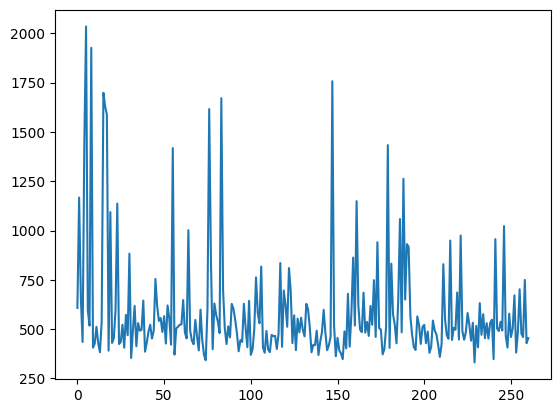

In [267]:
plt.plot([(v_ ** 2).sum() for v_ in saved_vs])

In [247]:
max_idxs = (*dims, max_L2s.indices.flatten())

In [248]:
least_squares_w[max_idxs]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [261]:
A_t_[max_idxs]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [259]:
(A_t[max_idxs] == (ks[...,None,:] * least_squares_w[...,None])[max_idxs]).all()

tensor(True)

In [238]:
ks.shape, least_squares_w.shape

(torch.Size([12, 396]), torch.Size([12, 396]))

In [235]:
max_idxs = (*dims, max_L2s.indices.flatten())

In [231]:
(ks == A_t[max_idxs]).all()
((ks[...,None,:] * A_t)[max_idxs] == ks ** 2).all()

tensor(True)

In [233]:
(ks[...,None,:] * A_t).sum(dim=-1)[0,244]

tensor(9.7224)

In [236]:
least_squares_w[max_idxs]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [229]:
(ks ** 2).sum(dim=-1)

tensor([ 9.7224,  1.9987,  2.2610,  2.0606,  1.5940,  1.6783,  5.0270,  2.8652,
         3.9411,  4.3703,  8.2305, 16.0674])

In [202]:
L2s.max(dim=-1)

torch.return_types.max(
values=tensor([ 9.7224,  1.9987,  2.2610,  2.0606,  1.5940,  1.6783,  5.0270,  2.8652,
         3.9411,  4.3703,  8.2305, 16.0674]),
indices=tensor([244,  69, 384, 340, 346, 105, 255, 145, 274,  40,  15,  24]))

In [186]:
max_L2s.indices

tensor([244,  69, 384, 340, 346, 105, 255, 145, 274,  40,  15,  24])

In [195]:
least_squares_w[(*dims, max_L2s.indices.flatten())]

tensor([1.1699e+00, 1.0003e+00, 1.1884e+00, 4.6980e-03, 8.5614e-01, 1.2867e-23,
        4.7932e-05, 1.9537e-25, 3.8841e-05, 6.7744e-03, 2.2210e-11, 2.4370e-05])

In [166]:
ks.shape

torch.Size([12, 396])

In [169]:
## put K dimension first
A_t = A.transpose(-2, -1)

# L2-normalize attention matrix
A_mean = A_t.mean(dim=-1)
L2 = (A_t ** 2).sum(dim=-1)

A_cross = A_t @ A_t.transpose(-2, -1)
# optimal selection of m minimizing ||(x_hat * m - x)||^2 for vectors x_hat, x:
# m = (x_hat * x).sum() / (x_hat**2).sum()
least_squares_w = A_cross / L2[...,None]
# err = (x_hat * m - x) ** 2



In [170]:
least_squares_w.shape

torch.Size([12, 396, 396])

In [148]:
L2 = ((A_t ** 2).sum(dim=-1) ** 0.5)
A_n = A_t / L2[...,None]
A_n[L2 == 0] = 0
sims = A_n @ A_n.transpose(-2, -1)
sums = sims.sum(dim=-1)
saved_k = []
saved_w = []

for i in tqdm(range(e)):
    idx = sums.argmax(dim=-1)
    dims = get_tensor_elem_idx(*amax.shape)
    ks = torch.zeros_like(sums)
    ks[dims] = A_n[(*dims, amax.flatten())]
    

  0%|          | 0/400 [00:00<?, ?it/s]

In [77]:
from tensor_util import get_tensor_elem_idx

In [142]:
L2.

torch.Size([12, 396])

In [149]:
# adjust sims, removing information that is accounted for by newly added keys
amax = sums.argmax(dim=-1)
dims = get_tensor_elem_idx(*amax.shape)
ks = torch.zeros_like(sums)
ks[dims] = A_n[(*dims, amax.flatten())]  # next best k to add for each attention head

In [174]:
torch.max(sums, dim=-1).indices

tensor([288,  55, 234,  87, 345, 386,  58,  45, 219, 304, 187, 308])

In [175]:
sums.argmax(dim=-1)

tensor([288,  55, 234,  87, 345, 386,  58,  45, 219, 304, 187, 308])

In [161]:
sims.shape

torch.Size([12, 396, 396])

In [160]:

ks.shape

torch.Size([12, 396])

In [157]:
ks.shape

torch.Size([12, 396])

In [125]:
ks[(*dims, amax.flatten())].shape

torch.Size([24])

In [127]:
ks.shape

torch.Size([2, 12, 396])

In [116]:
dims

(tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),)

torch.Size([24])

In [80]:
amax

tensor([244,  48, 167, 296, 346,  23, 255, 145,  57, 263,  15,  24])

In [84]:
*dims, k_idx = get_tensor_elem_idx(*A_n.shape[:-1])
A_n[(*dims, k_idx.flatten())].shape

torch.Size([4752, 396])

In [99]:
*dims, k_idx = get_tensor_elem_idx(*amax.shape)

In [101]:
amax.shape

torch.Size([12])

In [98]:
A_n[(*dims, amax.flatten())]

TypeError: slice expected at least 1 argument, got 0

In [97]:
amax.flatten()

tensor([244,  48, 167, 296, 346,  23, 255, 145,  57, 263,  15,  24])

In [90]:
k_idx.shape

torch.Size([4752])

In [68]:
amax

tensor([244,  48, 167, 296, 346,  23, 255, 145,  57, 263,  15,  24])

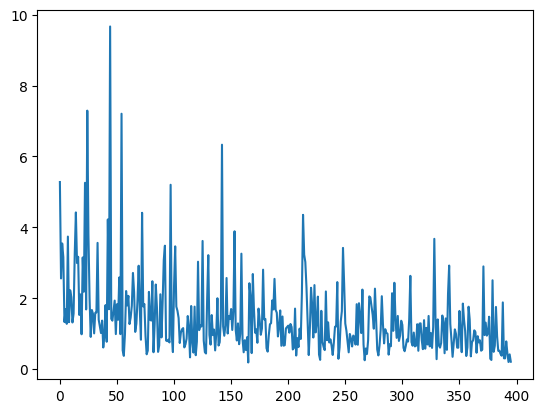

In [62]:
plt.plot(sums.mean(dim=0))

In [44]:
a= np.random.rand(5)
b = np.random.rand(5)
m = (a * b).sum() / (a**2).sum()


In [163]:
((a - b * m) ** 2).sum()

0.13518123731206982

In [45]:

a, b, m

(array([0.94901362, 0.27215402, 0.44879963, 0.88703959, 0.52695715]),
 array([0.95887287, 0.11678746, 0.50335309, 0.76877737, 0.31126865]),
 0.8986872119336449)

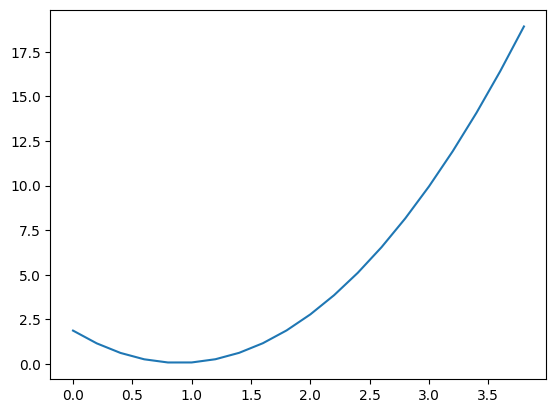

In [46]:
xs = np.arange(0, 4, 0.2)
plt.plot(xs, [((b - a*x)**2).sum() for x in xs])

In [44]:
sims.sum(dim=-1).min()

tensor(2.4747e-14)

In [41]:
sims[...,torch.diag(torch.ones(sims.shape[-1])).type(torch.bool)].max()

tensor(398.0422)

In [22]:
sims.min()

tensor(0.)